In [2]:
from atproto import Client

client = Client()

client.login(json.load(open("../data/bluesky_creds.json"))['login'], json.load(open("../data/bluesky_creds.json"))['password'])

NameError: name 'json' is not defined

gets batches of 100 

In [ ]:
# import os
# import sys
# sys.path.append('../src')
# from data_analysis import posts_df, retrieve_posts, textblob_analy

In [ ]:
#helper functions
# Extract relevant information from posts
def posts_df(posts):
    data = []
    for post in posts:
        data.append({
            "Post URI": post.uri,
            "Content": post.record.text,
            "Author": post.author.handle,
            "Timestamp": post.indexed_at,
            "Likes": post.like_count,
            "Replies": post.reply_count,
            "Reposts": post.repost_count
        })

    # Create DataFrame
    df = pd.DataFrame(data)
    return df

def retrieve_posts(params):
    all_posts = []
    while True:
        resp = client.app.bsky.feed.search_posts(params=params)
        posts = resp.posts
        print(f"Retrieved {len(posts)} posts")
        if len(posts) <=1:
            break
        all_posts.extend(posts)
        params['until'] = posts[-1].indexed_at

    #df=posts_df(all_posts)
    all_posts
    return all_posts


from textblob import TextBlob
def textblob_analy(df):
    p=[]
    s=[]
    for c in df['Content']:
        blob = TextBlob(c)
        sentiment = blob.sentiment
        p.append(round(sentiment.polarity, 3))
        s.append(round(sentiment.subjectivity, 2))
        #print(f"Polarity: {round(sentiment.polarity, 2)}, Subjectivity: {round(sentiment.subjectivity, 2)}")
        #print(f"Polarity: {sentiment.polarity}, Subjectivity: {round(sentiment.subjectivity, 2)}")

    df['subjectivity']=s
    df['polarity']=p

In [ ]:
# # loop over many 100 batched 
# #define time point eg after election till now

# params = {'q': 'germany election', 'limit': 100,
#           'since': '2025-02-15T12:00:00Z', 'until' : '2025-02-23T12:00:00Z'
#           }

# all_posts = retrieve_posts(params)
# df=posts_df(all_posts)
# textblob_analy(df)
# df.to_json('../data/before_posts.json', orient='records', lines=True)

In [ ]:
# params = {'q': 'germany election', 'limit': 100,
#           'since': '2025-02-23T12:00:00Z', 'until' : '2025-02-27T12:00:00Z'
#           }

# all_posts = retrieve_posts(params)
# df=posts_df(all_posts)
# textblob_analy(df)
# df.to_json('../data/after_posts.json', orient='records', lines=True)

In [ ]:
## try for individual parties
# params = {'q': 'germany election AFD', 'limit': 100,
#           'since': '2025-02-22T12:00:00Z', 'until' : '2025-02-23T12:00:00Z'
#           }
# all_posts = retrieve_posts(params)
# afd_df=posts_df(all_posts)
# textblob_analy(afd_df)
# afd_df.to_json('../data/afd_posts.json', orient='records', lines=True)

just use the already retrieved posts

In [4]:
import json
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# use seaborn style
sns.set()
sns.set_style('darkgrid')

In [5]:
#helper functions
from bs4 import BeautifulSoup
import re

def remove_html(text):
    return BeautifulSoup(text, "html.parser").get_text()


def punctuation_removal(r):
    punc = '!()-[]{};:""\,<>./?@#$%^&*_~'
    for ele in r:
        if ele in punc:
            r = r.replace(ele, "")
    return r

#helper function to remove urls from toots
def remove_url(txt):
    """Replace URLs found in a text string with nothing.
    It will remove the URL from the string.

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """
    
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', txt)

    return no_url

<>:10: SyntaxWarning: invalid escape sequence '\,'
<>:10: SyntaxWarning: invalid escape sequence '\,'
C:\Users\Tony Kelly\AppData\Local\Temp\ipykernel_25764\3586186073.py:10: SyntaxWarning: invalid escape sequence '\,'
  punc = '!()-[]{};:""\,<>./?@#$%^&*_~'


In [6]:
df_b = pd.read_json('../data/before_posts.json', orient='records', lines=True)
df_a = pd.read_json('../data/after_posts.json', orient='records', lines=True)

In [7]:
print(df_a['Content'][18])
#print(remove_html(df_a['Content'][18]))
print(remove_url(df_a['Content'][18]))

The Rise Of The Far Right In Germany Is No Ordinary Shift

https://www.europesays.com/1877983/

The 2025 German federal election has brought a shift in Europe’s political landscape. The Christian Democratic Union (CDU/CSU)…
The Rise Of The Far Right In Germany Is No Ordinary Shift



The 2025 German federal election has brought a shift in Europe’s political landscape. The Christian Democratic Union (CDU/CSU)…


In [8]:
df_a['Content'] = df_a['Content'].apply(remove_html)
df_a['Content'] = df_a['Content'].apply(remove_url)

C:\Users\Tony Kelly\AppData\Local\Temp\ipykernel_25764\3586186073.py:6: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  return BeautifulSoup(text, "html.parser").get_text()


In [11]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [9]:
text = " ".join(post for post in df_b['Content'])
print ("There are {} words in the combination of all posts.".format(len(text)))

There are 442786 words in the combination of all posts.


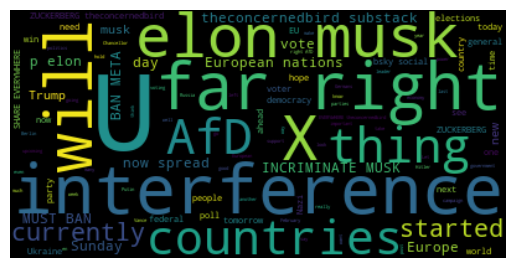

In [12]:
# Create and generate a word cloud image:
stopwords = set(STOPWORDS)
stopwords.update(["Germany", 'German', 
                  'election', "GermanElection2025", "GermanPolitics", 
                  "https", "POLITICO", 'results', 'S'
                 ])

wordcloud = WordCloud(stopwords=stopwords, max_words=100).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#map to an image of germany

In [13]:
import plotly.graph_objects as go


fig = go.Figure(
    data=[
        go.Scatter(x=df_b['polarity'], y=df_b['subjectivity'],
            mode="markers",
            marker={"size": np.sqrt(df_b['Likes'])},
            text=df_b['Content'],
            hovertemplate="<b>Polarity: %{x:.2f}</b><br>" +
            "Subjectivity: %{y:.2f}<br>" +
            "Content: %{text}<br>" +
            "<extra></extra>"
                   ),
        # go.Scatter(x=df_a['polarity'], y=df_a['subjectivity'],
        #     mode="markers",
        #     marker={"size": np.sqrt(df_a['Likes']), "color": "red"},
        #     text=df_a['Content'],
        #     hovertemplate="<b>Polarity: %{x:.2f}</b><br>" +
        #     "Subjectivity: %{y:.2f}<br>" +
        #     "Content: %{text}<br>" +
        #     "<extra></extra>"
        #            )
    ],
    layout=go.Layout(title=go.layout.Title(text="subjectivity vs polarity"))
)

fig.show()

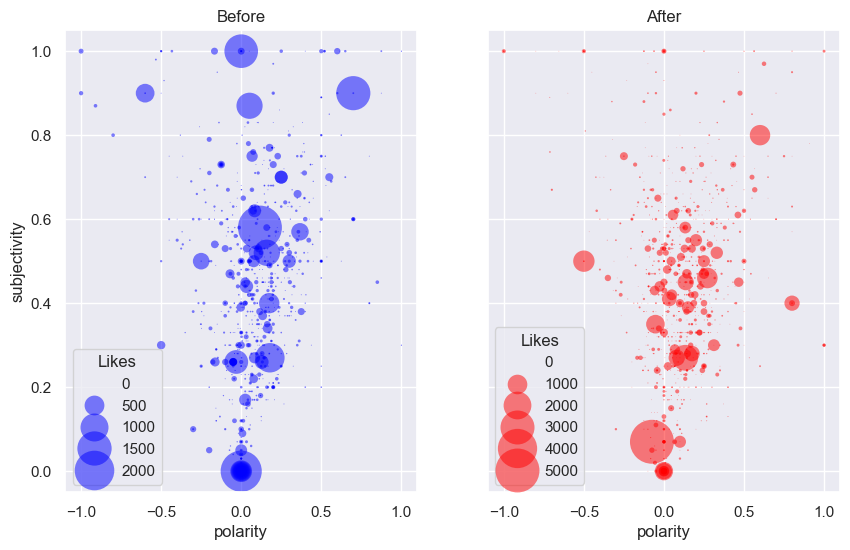

In [14]:
from sklearn.preprocessing import MinMaxScaler

###  normalization didn't work for me
combined_data = pd.concat([pd.DataFrame(df_b), pd.DataFrame(df_a)])

scaler = MinMaxScaler(feature_range=(0, 5000))
combined_data['Likes'] = scaler.fit_transform(combined_data[['Likes']])

# Separate the normalized data back into original datasets
df_b_norm = combined_data.iloc[:len(df_b)]
df_a_norm = combined_data.iloc[len(df_a):]

fig, ax = plt.subplots(1,2, figsize=(10, 6), sharey=True)
sns.scatterplot(x=df_b_norm['polarity'], y=df_b_norm['subjectivity'],
                size=df_b_norm['Likes'],
                sizes=(0, 1000),  # Adjust the range of marker sizes
                color='blue',
                alpha=0.5,
                ax=ax[0])
sns.scatterplot(x=df_a_norm['polarity'], y=df_a_norm['subjectivity'],
                size=df_a_norm['Likes'],
                sizes=(0, 1000), 
                color='red', 
                alpha=0.5,
                ax=ax[1])
             

ax[0].set_title('Before')
ax[1].set_title('After')

fig.savefig('../figs/sentiment_scatter.svg')

I like the scatter plots but they are difficult to parse quickly 
Maybe be easier to plot the histograms or density plots and look at shifts in the distribution

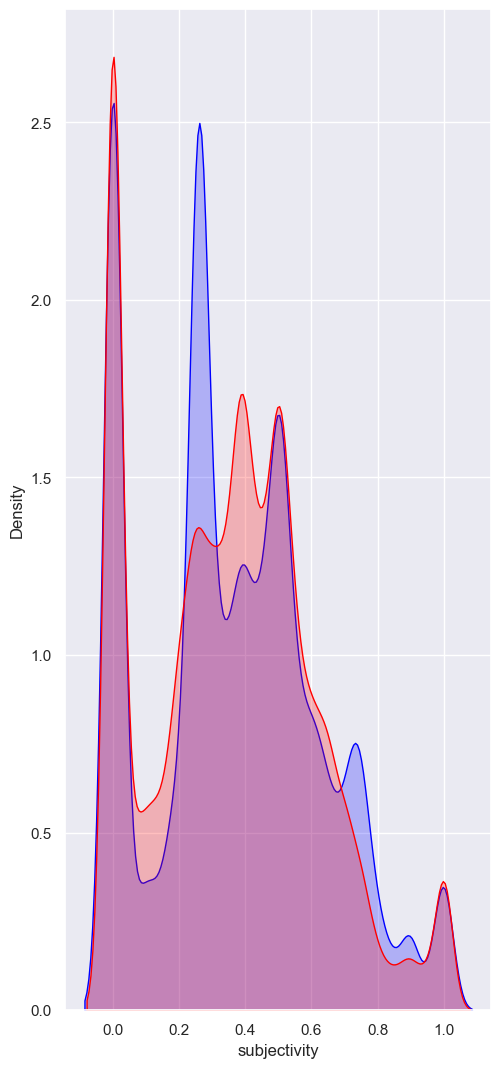

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
# sns.histplot(data=df, x='subjectivity', ax=ax)
# sns.histplot(data=AFD_df, x='subjectivity', ax=ax, color='red')

sns.kdeplot(df_b, x='subjectivity', color='blue', fill=True, label='Distribution 1', bw_adjust=0.5)
sns.kdeplot(df_a, x='subjectivity', color='red', fill=True, label='Distribution 2', bw_adjust=0.5)

fig.savefig('../figs/subjectivity_histo.svg')

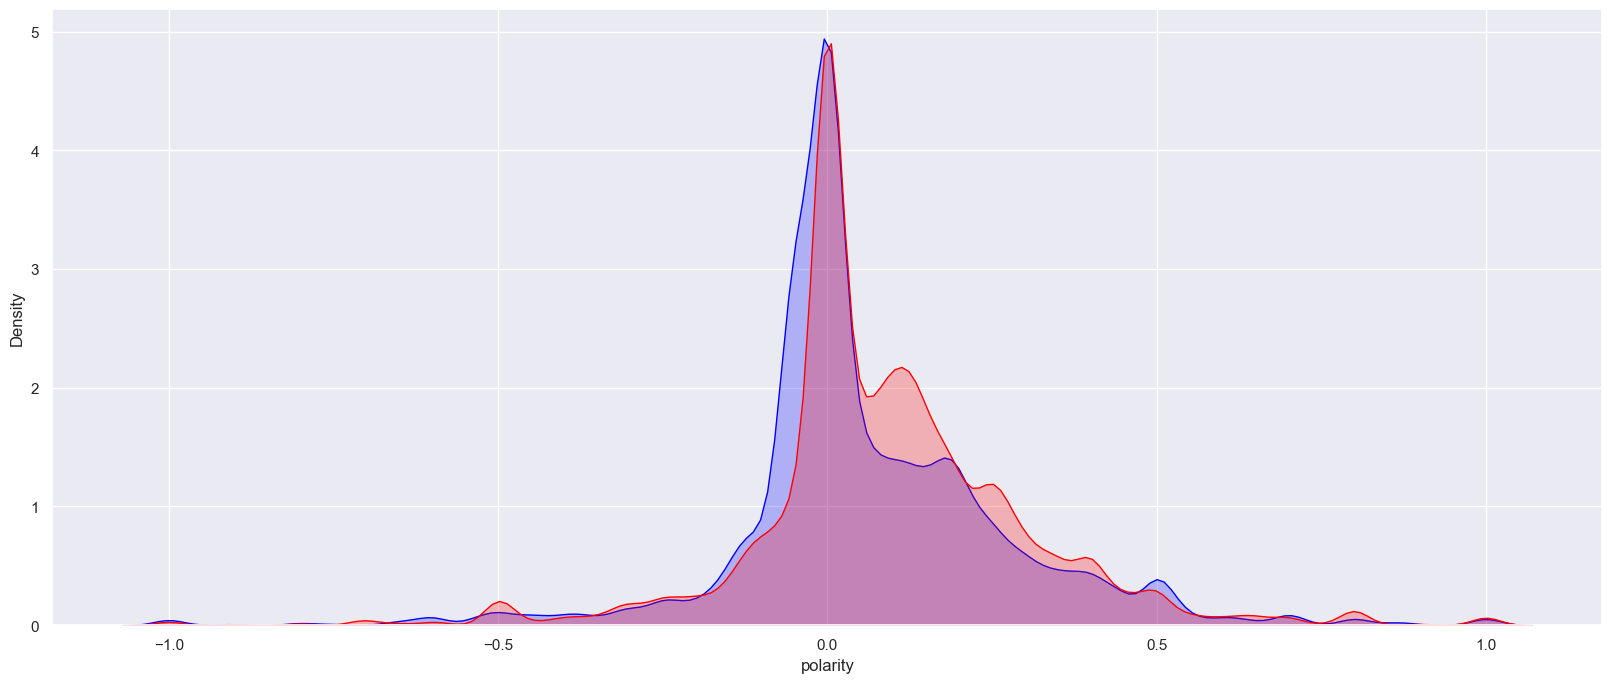

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
# sns.histplot(data=df, x='subjectivity', ax=ax)
# sns.histplot(data=AFD_df, x='subjectivity', ax=ax, color='red')

sns.kdeplot(df_b, x='polarity', color='blue', fill=True, label='Distribution 1', bw_adjust=0.5)
sns.kdeplot(df_a, x='polarity', color='red', fill=True, label='Distribution 2', bw_adjust=0.5)

fig.savefig('../figs/polarity_histo.svg')

In [ ]:
### to do cleaning and tokenising

# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

# stop_words = set(stopwords.words('english'))

# def filter_words(df):
#     filtered = []
#     for reviews in df['Content']:
#         word_tokens = word_tokenize(reviews)
#         for w in word_tokens:
#                 if w not in stop_words and w.isalpha():
#                     filtered.append(w)
#     return (filtered)

#filter_words(df)

In [17]:
df_a['period']='after'
df_b['period']='before'
df=pd.concat([df_a, df_b])

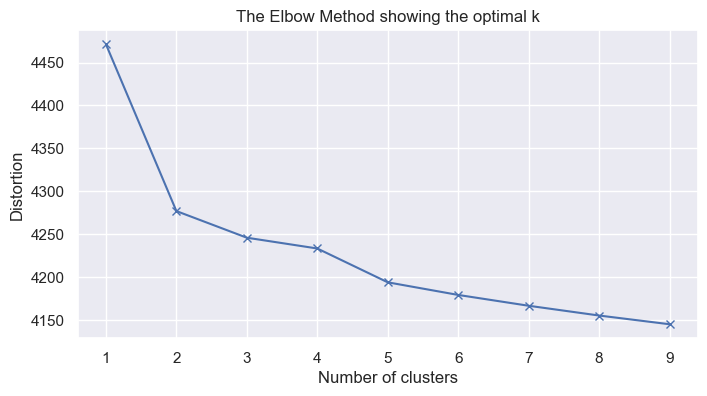

In [18]:
def plot_elbow_method(dfs):
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(dfs["Content"])

    distortions = []
    K = range(1, 10)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 4))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

plot_elbow_method(df)

In [19]:
def vectorise_posts(df):
    # Vectorize the posts using TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    matrix = vectorizer.fit_transform(df['Content']).toarray()
    feature_names = vectorizer.get_feature_names_out()
    df_tfidf = pd.DataFrame(matrix, columns=feature_names)
    #print(df_tfidf)

    X = vectorizer.fit_transform(df["Content"])

    # Determine the optimal number of clusters using the elbow method
    import matplotlib.pyplot as plt



    return X, matrix, feature_names, df_tfidf

X, matrix, feature_names, df_tfidf = vectorise_posts(df)

In [20]:
# Cluster the posts using K-Means
num_clusters = 5  # Set the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Add the cluster labels to the DataFrame
df["Cluster"] = kmeans.labels_

# Display the clustered DataFrame
print(df[['Content','Cluster', 'Likes']])

                                                Content  Cluster  Likes
0     Make no mistake. Yes, it seems that multi-part...        0     10
1     🇩🇪 🗳️ @jannikjansen.bsky.social, @lindnerjs.bs...        3      4
2     We need a true leader who will demand an audit...        4      0
3     We need a true leader who will demand an audit...        4      2
4     We need a true leader who will demand an audit...        4      0
...                                                 ...      ...    ...
1988  2/2\nOn Feb. 23 we'll have elections in German...        3      1
1989  2/2\nOn Feb. 23 we'll have elections in German...        3      1
1990  oh... & btw: #IVoteVolt! in the upcoming #elec...        3      1
1991  The european leaders are piiiiiiiiissed. It's ...        3      8
1992  At 23.02.25 we will have election-day!\n\nWe h...        3     21

[4580 rows x 3 columns]


In [21]:
# Import Latent Dirichlet Allocation
from sklearn.decomposition import LatentDirichletAllocation

# Apply LDA to the TF-IDF matrix
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(matrix)

# Display the topics
def display_topics(model, feature_names, no_top_words):
	for topic_idx, topic in enumerate(model.components_):
		print("Topic %d:" % (topic_idx))
		print(" ".join([feature_names[i]
						for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, feature_names, no_top_words)

# Get the topic distribution for each document
topic_distribution = lda.transform(matrix)
df["Topic"] = topic_distribution.argmax(axis=1)

Topic 0:
germany election afd right day party trump musk won nazi
Topic 1:
germany election right afd far german merz party cdu polls
Topic 2:
germany election bsky afd day social musk vote german don
Topic 3:
doing currently thing interference countries spread started nations substack musks
Topic 4:
germany election german midnight says right europe afd far bsky


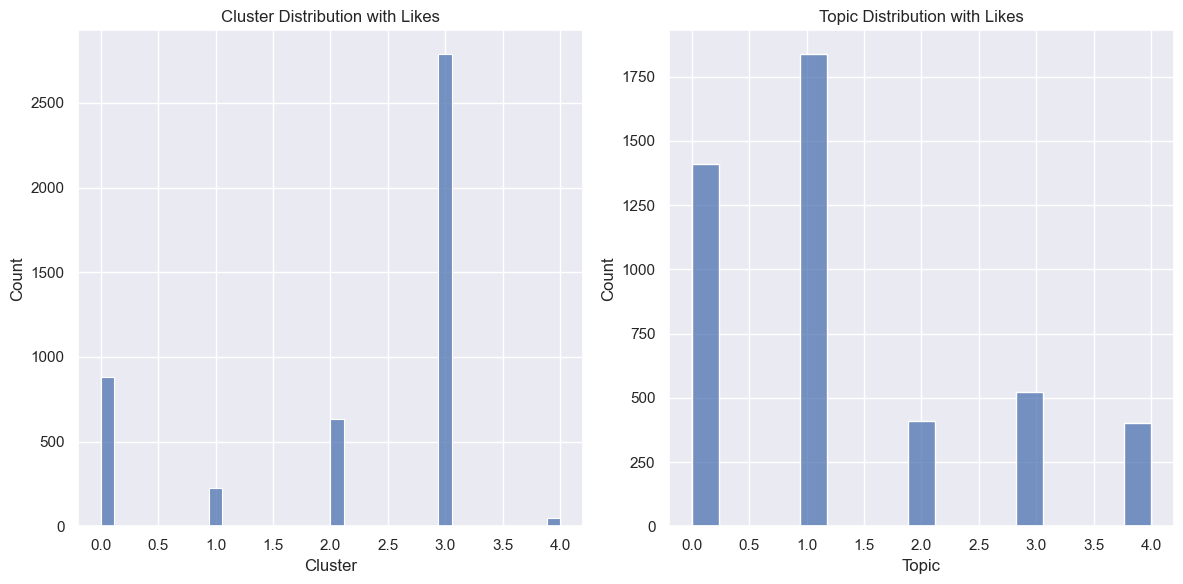

In [22]:
##HERE USE PIE CHART
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# #get sum likes
# df['Cluster_Likes'] = df.groupby('Cluster')['Likes'].transform('sum')
# df['Topic_Likes'] = df.groupby('Topic')['Likes'].transform('sum')

sns.histplot(df, x='Cluster', ax=ax[0]) #hue='Cluster_Likes', palette='viridis', 
ax[0].set_title('Cluster Distribution with Likes')

#df['Topic_Likes'] = df.groupby('Topic')['Likes'].transform('sum')

sns.histplot(df, x='Topic', ax=ax[1]) #hue='Topic_Likes', palette='viridis', 
ax[1].set_title('Topic Distribution with Likes')

plt.tight_layout()
plt.show()

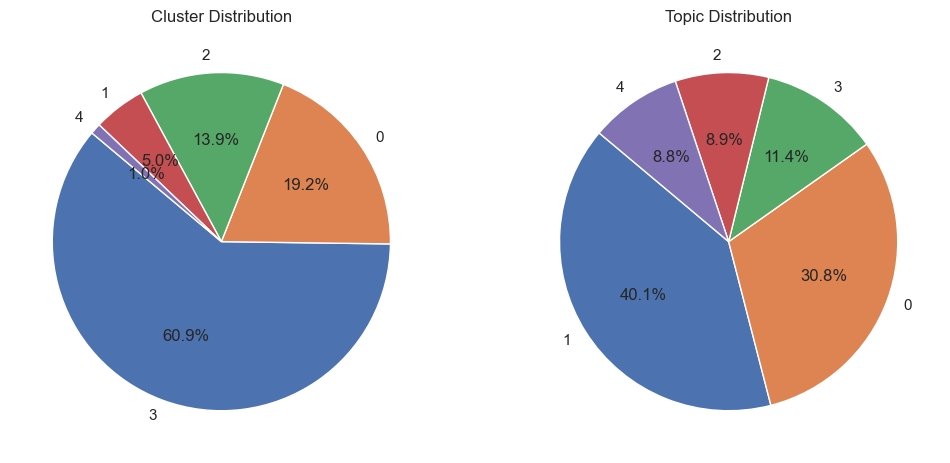

In [23]:
#plot piechart of histogram
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
cluster_counts = df['Cluster'].value_counts()
ax[0].pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140)
ax[0].set_title('Cluster Distribution')

topic_counts = df['Topic'].value_counts()
ax[1].pie(topic_counts, labels=topic_counts.index, autopct='%1.1f%%', startangle=140)
ax[1].set_title('Topic Distribution')

fig.savefig('../figs/clusters_pie.svg')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your DataFrame 'df'
# Calculate the counts for each cluster and sort them in descending order
cluster_counts = df['Cluster'].value_counts().sort_values(ascending=False)
sorted_clusters = cluster_counts.index

# Map the 'Cluster' column to the sorted order using CategoricalDtype
df['Cluster'] = pd.Categorical(df['Cluster'], categories=sorted_clusters, ordered=True)

# Create a new DataFrame with the sorted clusters
df_sorted = df.sort_values(by='Cluster')

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(df_sorted, x='Cluster', ax=ax)
ax.set_title('Cluster Distribution with Likes')
plt.show()


[2, 2, 4, 4, 4, ..., 2, 2, 2, 2, 2]
Length: 4580
Categories (5, int32): [2 < 0 < 3 < 1 < 4]

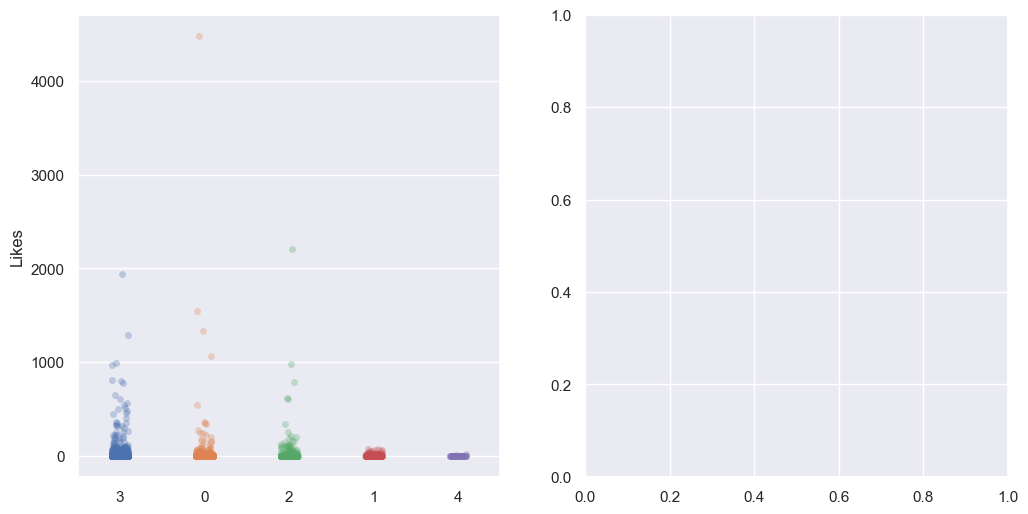

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

order = [3, 0, 2, 1, 4]
for x, i in enumerate(order):
    sns.stripplot(data=df[df['Cluster'] == i], x=x, y='Likes', alpha=0.3, ax=ax[0])
    # sns.stripplot(data=df[df['Cluster'] == 0], x=0, y='Likes', alpha=0.3)
    # sns.stripplot(data=df[df['Cluster'] == 3], x=3, y='Likes', alpha=0.3)
    # sns.stripplot(data=df[df['Cluster'] == 1], x=1, y='Likes', alpha=0.3)
    # sns.stripplot(data=df[df['Cluster'] == 4], x=4, y='Likes', alpha=0.3)
ax[0].set_xticks(range(len(order)))
ax[0].set_xticklabels(order);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


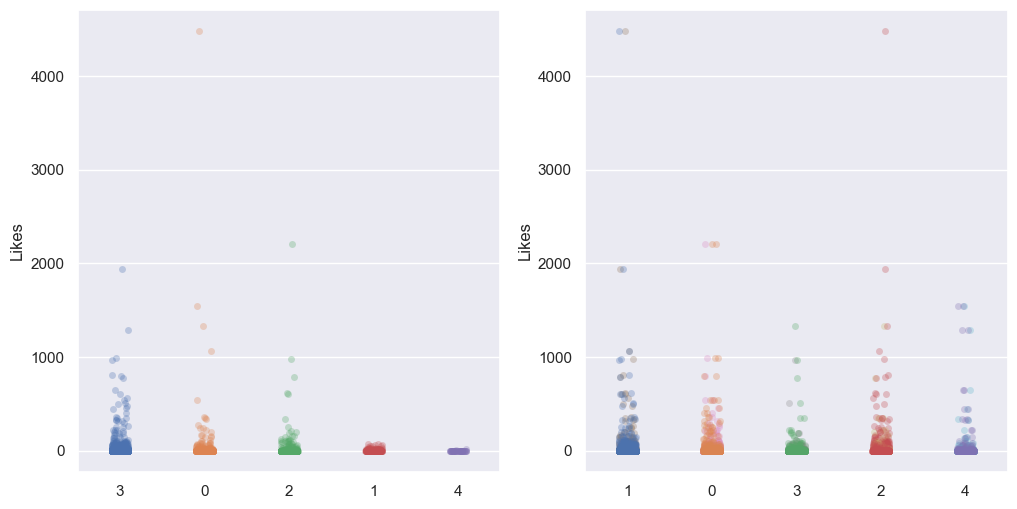

In [37]:
order = [1, 0, 3, 2, 4]
for x, i in enumerate(order):
    sns.stripplot(data=df[df['Topic'] == i], x=x, y='Likes', alpha=0.3, ax=ax[1])

# Label the x ticks according to order
ax[1].set_xticks(range(len(order)))
ax[1].set_xticklabels(order)
fig.savefig('../figs/cluster-likes_scatter.eps')
fig

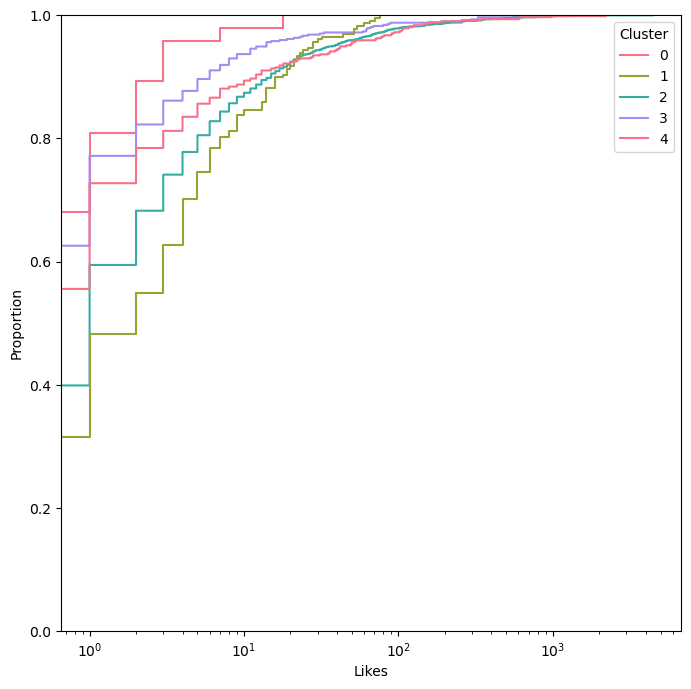

In [45]:
# Define your custom color palette
palette = sns.color_palette("husl", as_cmap=True)  # "husl" is just an example; you can choose any palette

fig, ax = plt.subplots(figsize=(8, 8))
# sns.histplot(data=df, x='Likes', hue='Cluster', cumulative=True, stat="density", common_norm=False, ax=ax)
# ax.set_xscale('log')
sns.ecdfplot(data=df, x='Likes', hue='Cluster', palette=palette)
plt.xscale('log')  # Set the x-axis to a logari

#sns.histplot(data=Adf, x='subjectivity', ax=ax, color='red')

#sns.kdeplot(df_b, x='subjectivity', fill=True, label='Distribution 1', bw_adjust=0.5)
#sns.kdeplot(df_a, x='subjectivity', fill=True, label='Distribution 2', bw_adjust=0.5)

In [24]:
# try to get top word for each cluster and get unique words WORKIN
def top_words(df):
    top_words={}
    
    for i in df['Cluster'].unique():
        cl = df[df['Cluster'] == i]

        #indicies
        cl_indices = cl.index

        # TF-IDF values for the posts in the cluster
        cl_tfidf = matrix[cl_indices]
        
        # Calculate the mean TF-IDF score for each word in cluster 1
        cl_mean_tfidf = cl_tfidf.mean(axis=0)
        
        # Get the words with the highest mean TF-IDF scores
        top_words_indices = cl_mean_tfidf.argsort()[::-1][:10]
        top_words = [feature_names[n] for n in top_words_indices]
        print(f"Top words for cluster {i}:", top_words)

    

In [23]:
df['Cluster'].unique()

array([2, 4, 3, 0, 1], dtype=int32)

In [25]:
top_words(df)

Top words for cluster 2: ['germany', 'election', 'afd', 'results', 'party', 'german', 'right', 'merz', 'won', 'trump']
Top words for cluster 4: ['audit', 'elon', 'panama', 'mexico', 'greenland', 'demand', 'true', 'nov', 'canada', 'non']
Top words for cluster 3: ['www', 'germany', 'com', 'merz', 'election', '2025', 'live', 'german', 'https', 'europe']
Top words for cluster 0: ['right', 'far', 'afd', 'germany', 'party', 'election', 'merz', 'alternative', 'second', 'german']
Top words for cluster 1: ['germany', 'election', 'afd', 'party', 'german', 'results', 'right', 'merz', 'trump', 'victory']
